In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Load Data

In [2]:
import boto3
from io import BytesIO
from fastparquet import ParquetFile

s3 = boto3.client("s3")
response = s3.list_objects_v2(Bucket='covid-19-prj', Prefix ='raw/brasil.io/')
all_objects = [item.get('Key') for item in response.get('Contents')][1:]

def read_parquet_from_s3(keyName):
    obj = s3.get_object(Bucket='covid-19-prj', Key=keyName)
    df = obj['Body'].read()
    return ParquetFile(BytesIO(df)).to_pandas()

dataframes = [read_parquet_from_s3(key_name) for key_name in all_objects]
df = pd.concat(dataframes, axis=0)

## Overview

In [3]:
df.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
index,,,,,,,,,,,,
9877,2020-02-25,SP,None,state,1,0,1,False,45919049.0,35.0,0.00218,0.0
17378,2020-02-25,SP,São Paulo,city,1,0,1,False,12252023.0,3550308.0,0.00816,0.0
9876,2020-02-26,SP,None,state,1,0,2,False,45919049.0,35.0,0.00218,0.0
17377,2020-02-26,SP,São Paulo,city,1,0,2,False,12252023.0,3550308.0,0.00816,0.0
9875,2020-02-27,SP,None,state,1,0,3,False,45919049.0,35.0,0.00218,0.0


In [4]:
df.describe()

,confirmed,deaths,order_for_place,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
count,51950.000000,51950.000000,51950.000000,5.194600e+04,5.194600e+04,50829.000000,51950.000000
mean,32.376574,2.109240,15.281752,1.392398e+05,3.226160e+06,18.810169,0.078098
std,372.858904,29.806669,11.209619,8.094702e+05,9.622974e+05,37.795769,0.208538
min,0.000000,0.000000,1.000000,1.149000e+03,3.500000e+01,0.002180,0.000000
25%,1.000000,0.000000,6.000000,1.635400e+04,2.515807e+06,3.856690,0.000000
50%,2.000000,0.000000,13.000000,3.471000e+04,3.203403e+06,8.645530,0.000000
75%,7.000000,1.000000,22.000000,9.252600e+04,4.112702e+06,19.523180,0.031200
max,23187.000000,1910.000000,63.000000,4.591905e+07,5.300108e+06,953.615410,1.000000


In [5]:
df.dtypes

date                               object
state                              object
city                               object
place_type                         object
confirmed                           int64
deaths                              int64
order_for_place                     int64
is_last                              bool
estimated_population_2019         float64
city_ibge_code                    float64
confirmed_per_100k_inhabitants    float64
death_rate                        float64
dtype: object

In [6]:
# Take a look at the date type
np.array([isinstance(x, str) for x in df.date]).all()

True

In [7]:
df.place_type.value_counts(normalize=True)

city     0.999827
state    0.000173
Name: place_type, dtype: float64

## EDA

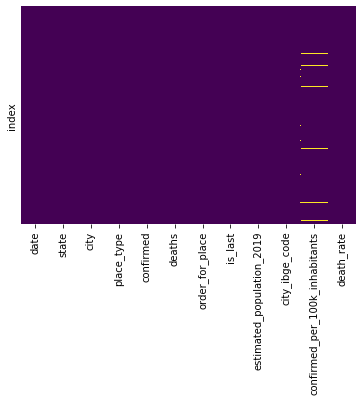

In [8]:
# Missing values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [9]:
# For more details
display(df.isnull().sum().sort_values(ascending=False))

confirmed_per_100k_inhabitants    1121
city                                 9
city_ibge_code                       4
estimated_population_2019            4
death_rate                           0
is_last                              0
order_for_place                      0
deaths                               0
confirmed                            0
place_type                           0
state                                0
date                                 0
dtype: int64

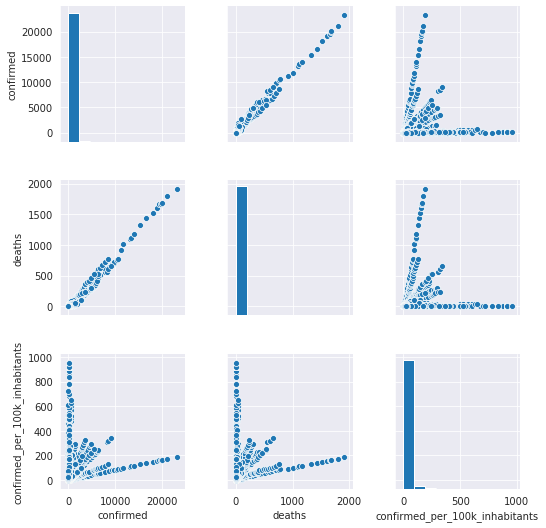

In [11]:
columns = [
    'confirmed',	 
    'deaths', 
    'confirmed_per_100k_inhabitants'
]
sns.set_style("darkgrid")
sns.pairplot(df[columns])

In [12]:
# Unify the date column format
df['date'] = pd.to_datetime(df.date).dt.date
# Sort dates
df = df.sort_values('date')
df = df.dropna(subset=['city'])
df = df.loc[df.place_type == 'city']
cumulated = df.groupby('date').agg({'confirmed': 'sum', 
                                    'deaths': 'sum', 
                                    'confirmed_per_100k_inhabitants': 'sum'}).reset_index()

In [13]:
cumulated.describe()

,confirmed,deaths,confirmed_per_100k_inhabitants
count,72.00000,72.000000,72.000000
mean,23360.37500,1521.875000,13279.195114
std,32441.91548,2264.295506,21069.830422
min,1.00000,0.000000,0.008160
25%,82.00000,0.000000,58.930340
50%,6258.50000,221.500000,1969.211595
75%,37106.25000,2382.250000,17783.386937
max,113299.00000,7797.000000,80030.634510


/home/ubuntu/anaconda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


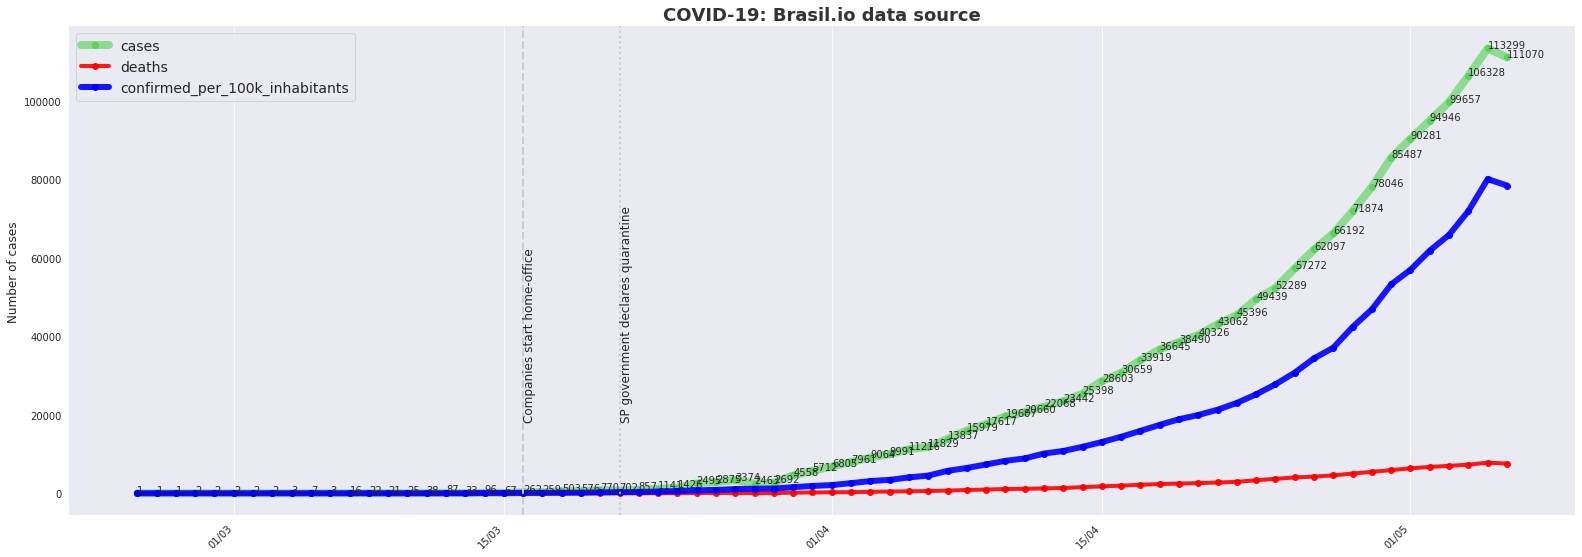

In [14]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline

fig, ax = plt.subplots(figsize=(27, 9))

plt.plot(cumulated['date'], cumulated['confirmed'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
plt.plot(cumulated['date'], cumulated['deaths'], color='red', linewidth=4, alpha=0.9, marker='o')
plt.plot(cumulated['date'], cumulated['confirmed_per_100k_inhabitants'], color='blue', linewidth=6, alpha=0.9, marker='o')


[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated['date'], cumulated['confirmed'])]

plt.xticks(rotation=45, ha='right')
plt.title('COVID-19: Brasil.io data source', fontsize=18, fontweight='bold', color='#333333')

plt.ylabel('Number of cases', fontsize=12)
plt.xlabel(None)

plt.axvline('2020-03-16', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
ax.annotate('Companies start home-office', xy=('2020-03-16',19000), fontsize=12, rotation=90)
plt.axvline('2020-03-21', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
ax.annotate('SP government declares quarantine', xy=('2020-03-21',19000), fontsize=12, rotation=90)

plt.legend(loc=2, labels=['cases','deaths', 'confirmed_per_100k_inhabitants'], fontsize=14)

plt.grid(which='major', axis='y')
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.show();

In [15]:
np.all(np.diff(cumulated.confirmed) >= 0)

False

In [16]:
np.all(np.diff(cumulated.deaths) >= 0)

False

*The number of cases must be incremented, so we must correct the wrong observations*

In [17]:
def func(cdf, col):
    if np.all(np.diff(cdf[col]) >= 0):
        # Stop condition
        return cdf[col]
    else:
        # Treatment
        cdf['diff'] = cdf[col].diff() >= 0
        cdf['diff'].iloc[0] = True 
        cdf[col] = cdf.apply(lambda row: np.nan if (row['diff'] == False) else row[col], axis=1)
        cdf[col].fillna(method='ffill', inplace=True)
        return func(cdf, col)

# Correct the wrong obs
cumulated['confirmed'] = func(cumulated.copy(), 'confirmed')
cumulated['deaths'] = func(cumulated.copy(), 'deaths')

/home/ubuntu/anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
cumulated.head()

,date,confirmed,deaths,confirmed_per_100k_inhabitants
0,2020-02-25,1.0,0.0,0.00816
1,2020-02-26,1.0,0.0,0.00816
2,2020-02-27,1.0,0.0,0.00816
3,2020-02-28,2.0,0.0,0.01632
4,2020-02-29,2.0,0.0,0.01632


### Confirmed cases distribution

/home/ubuntu/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/ubuntu/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ubuntu/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


[Text(0.5, 0, '')]

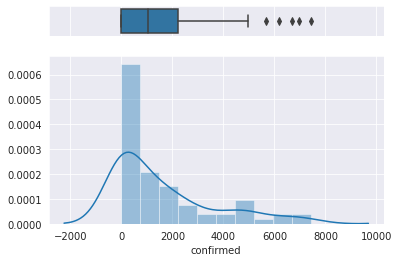

In [19]:
confirmed_cases = cumulated.confirmed.diff()

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(confirmed_cases, ax=ax_box)
sns.distplot(confirmed_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

### Death cases distribution

/home/ubuntu/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/ubuntu/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ubuntu/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


[Text(0.5, 0, '')]

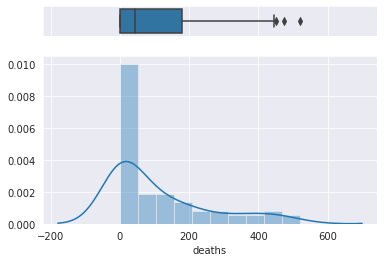

In [20]:
deaths_cases = cumulated.deaths.diff()

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(deaths_cases, ax=ax_box)
sns.distplot(deaths_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [16]:
# Let's take a look at the number of cities per date
#y = df.groupby('date').agg({'city': (lambda x: x.nunique())})
#sns.distplot(y.city, bins=10)